In [1183]:
%pip install -q exchange_calendars
%pip install -q equinox

/usr/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext jupyter_ai_magics

In [922]:
import requests
import datetime
from zoneinfo import ZoneInfo
from typing import Any
from collections import namedtuple
import rich
from rich import progress
import pandas as pd
import numpy as np
import exchange_calendars as xcals
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
# import plotly.express as px
# import plotly.io as pio
# pio.templates.default = 'plotly'
import pydantic
from sklearn.decomposition import PCA

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from functools import partial
# import blackjax
# import optax
import concurrent.futures

import pyarrow as pa
import redis
pd.set_option('display.max_columns', 500)

In [4]:
conn = redis.Redis(host='192.168.0.70', db=4, decode_responses=False)

In [5]:
NaN = float('nan')

def _to_datetime(x: Any) -> Any:
    if isinstance(x, str) and len(x) == 27 and x[-1] == "Z" and x[10] == "T":
        return datetime.datetime.fromisoformat(x).astimezone(ZoneInfo('US/Eastern'))
    return x

def _to_nan(x: Any) -> Any:
    if isinstance(x, float) and x > 1e9:
        return float("nan")
    return x

def replace_none_with_nan(records: list[namedtuple], fields: list[str]) -> list[namedtuple]:
    if not records:
        return records

    Record = type(records[0])
    result = []

    for record in records:
        values = list(record)
        for i, field in enumerate(record._fields):
            if field in fields and values[i] is None:
                values[i] = float("nan")
        result.append(Record(*values))

    return result

def _to_python_data(x: Any) -> Any:
    y = _to_datetime(x)
    return _to_nan(y)

def _sql_query_and_data(query: str, data: tuple) -> str:
    data = tuple(str(x).replace("[", "(").replace("]", ")") if isinstance(x, list) else x for x in data)
    sanitized_data = tuple(_sanitize_input(x) for x in data)
    if sanitized_data:
        result = query % sanitized_data
    else:
        result = query
    if "IN '('" in result and "')'" in result:
        result = result.replace("'('", "(").replace("')'", "')")
    return result

def _response_to_records(data: dict[str, Any], record_name: str | None = None) -> list[namedtuple]:
    columns = [col["name"] for col in data["columns"]]
    Record = namedtuple(record_name if record_name else "record", columns)
    dataset = data.get("dataset", [])
    return list(map(lambda x: Record(*map(_to_python_data, x)), dataset))

def _select(query: str, data: tuple, *, record_name: str | None = None) -> list[Any]:
    complete_query = _sql_query_and_data(query, data)
    params = dict(query=complete_query)
    response = requests.get(
        "http://192.168.0.70:9000/exec",
        params=params,
        timeout=30.0,
    )
    if response.status_code != 200:
        try:
            msg = response.json()["error"]
            raise requests.exceptions.RequestException(msg)
        except:
            raise
    return _response_to_records(response.json())

In [1172]:
def get_df_from_sql() -> pd.DataFrame:
    records = replace_none_with_nan(_select(query = '''
        SELECT *
        FROM volquote
        WHERE iv_mid != null
    ''', data = ()), fields=('fwd', 'r', 'q', 'iv_bid', 'iv_mid', 'iv_ask'))
    df = pd.DataFrame(records)
    df = df.assign(log_strike=lambda x: np.log(x['strike_price'] / x['fwd']), OTM=lambda x: np.logical_or((x['strike_price'] <= x['fwd']) & (x['instrument_class'].eq('P')), (x['strike_price'] > x['fwd']) & (x['instrument_class'].eq('C'))))
    return df
# df = get_df_from_sql()
# df.shape

In [1187]:
def get_dfs_from_sql() -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    records = replace_none_with_nan(_select(query = '''
        SELECT *
        FROM volquote
        WHERE fwd != null
    ''', data = ()), fields=('fwd', 'r', 'q', 'iv_bid', 'iv_mid', 'iv_ask'))
    df_quotes = pd.DataFrame(records)
    df_quotes = df_quotes.assign(log_strike=lambda x: np.log(x['strike_price'] / x['fwd']), OTM=lambda x: np.logical_or((x['strike_price'] <= x['fwd']) & (x['instrument_class'].eq('P')), (x['strike_price'] > x['fwd']) & (x['instrument_class'].eq('C'))))


    records = replace_none_with_nan(_select(query = '''
        SELECT *
        FROM rolls
        WHERE asset = 'ES'
    ''', data = ()), fields=())
    df_rolls = pd.DataFrame(records)


    records = replace_none_with_nan(_select(query = '''
        SELECT *
        FROM ohlc
        WHERE period = '1m'
          AND ticker NOT LIKE '%-%'
    ''', data = ()), fields=('adjclose', 'open', 'close', 'low', 'high', 'volume'))
    df_futs = pd.DataFrame(records)
    
    return df_quotes, df_rolls, df_futs
df_quotes, df_rolls, df_futs = get_dfs_from_sql()
df_quotes.shape, df_rolls.shape, df_futs.shape

((2011412, 21), (31, 9), (4717386, 11))

In [1138]:
def save_dataframe_to_redis(conn: redis.Redis, df: pd.DataFrame, key_prefix: str):
    table = pa.Table.from_pandas(df)    
    binary_data = pa.ipc.serialize_pandas(df).to_pybytes()
    conn.set(f"df:{key_prefix}:data", binary_data)

def get_dataframe_from_redis(conn: redis.Redis, key_prefix: str):
    binary_data = conn.get(f"df:{key_prefix}:data")
    if binary_data is None:
        return None
    df = pa.ipc.deserialize_pandas(binary_data)   
    return df

In [ ]:
df_quotes.to_csv('data/ATC/quotes.csv', )

In [1196]:
df_futs

,source,ticker,raw_symbol,timestamp,period,open,high,low,close,adjclose,volume
0,databento,ESM17,ESM7,2017-05-21 18:00:00-04:00,1m,2381.75,2382.25,2381.00,2382.00,NaN,1632.0
1,databento,ESU17,ESU7,2017-05-21 18:00:00-04:00,1m,2378.50,2379.00,2378.50,2379.00,NaN,3.0
2,databento,ESM17,ESM7,2017-05-21 18:01:00-04:00,1m,2381.75,2382.00,2381.75,2381.75,NaN,209.0
3,databento,ESM17,ESM7,2017-05-21 18:02:00-04:00,1m,2382.00,2382.75,2382.00,2382.50,NaN,766.0
4,databento,ESU17,ESU7,2017-05-21 18:02:00-04:00,1m,2379.00,2379.00,2379.00,2379.00,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...
4717381,databento,ESZ24,ESZ4,2024-10-31 19:57:00-04:00,1m,5743.00,5743.75,5742.75,5743.25,NaN,98.0
4717382,databento,MESZ24,MESZ4,2024-10-31 19:58:00-04:00,1m,5743.25,5743.50,5743.00,5743.25,NaN,57.0
4717383,databento,ESZ24,ESZ4,2024-10-31 19:58:00-04:00,1m,5743.25,5743.50,5743.00,5743.25,NaN,124.0
4717384,databento,MESZ24,MESZ4,2024-10-31 19:59:00-04:00,1m,5743.25,5743.25,5742.50,5742.75,NaN,117.0


In [1189]:
if False:
    save_dataframe_to_redis(conn, df_quotes, key_prefix='volquote')
    save_dataframe_to_redis(conn, df_rolls, key_prefix='rolls')
    save_dataframe_to_redis(conn, df_futs, key_prefix='futs')

In [1194]:
df_rolls.to_csv('data/ATC/rolls.csv.bz2', )
# df_futs.to_csv('data/ATC/futs.csv.bz2', )

In [1195]:
if True:
    df_quotes.to_csv('data/ATC/quotes.csv.bz2', )
    df_rolls.to_csv('data/ATC/rolls.csv.bz2', )
    df_futs.to_csv('data/ATC/futs.csv.bz2', )

In [11]:
df_AsOfUnderlyingExpiration = df.dropna(subset=['fwd', 'iv_bid', 'iv_mid', 'iv_ask']).query('OTM').groupby(['asof', 'expiration', 'underlying', 't']).agg({'t': 'count', 'log_strike': ['min', 'max']})
df_AsOfUnderlyingExpiration

t  \
                                                                        count   
asof                      expiration                underlying t                
2017-05-22 15:48:00-04:00 2017-06-16 09:30:00-04:00 ESM7       0.067728    76   
                          2017-09-15 09:30:00-04:00 ESU7       0.316872   109   
                          2017-12-15 09:30:00-05:00 ESZ7       0.566131   101   
                          2018-03-16 09:30:00-04:00 ESH8       0.815161    97   
2017-05-23 15:48:00-04:00 2017-06-16 09:30:00-04:00 ESM7       0.064990    93   
...                                                                       ...   
2024-10-25 15:48:00-04:00 2025-12-19 09:30:00-05:00 ESZ5       1.149293    79   
                          2026-03-20 09:30:00-04:00 ESH6       1.398323    85   
                          2026-06-18 09:30:00-04:00 ESM6       1.644730    99   
                          2026-09-18 09:30:00-04:00 ESU6       1.896612    91   
                          2026-12-18 09:30:00-05:00 ESZ6       2.145870    64   

                                                                        log_strike  \
                                                                               min   
asof                      expiration                underlying t                     
2017-05-22 15:48:00-04:00 2017-06-16 09:30:00-04:00 ESM7       0.067728  -0.365861   
                          2017-09-15 09:30:00-04:00 ESU7       0.316872  -0.482806   
                          2017-12-15 09:30:00-05:00 ESZ7       0.566131  -0.797835   
                          2018-03-16 09:30:00-04:00 ESH8       0.815161  -0.550624   
2017-05-23 15:48:00-04:00 2017-06-16 09:30:00-04:00 ESM7       0.064990  -0.349122   
...                                                                            ...   
2024-10-25 15:48:00-04:00 2025-12-19 09:30:00-05:00 ESZ5       1.149293  -0.969046   
                          2026-03-20 09:30:00-04:00 ESH6       1.398323  -0.934718   
                          2026-06-18 09:30:00-04:00 ESM6       1.644730  -1.229866   
                          2026-09-18 09:30:00-04:00 ESU6       1.896612  -1.643193   
                          2026-12-18 09:30:00-05:00 ESZ6       2.145870  -1.001224   

                                                                                   
                                                                              max  
asof                      expiration                underlying t                   
2017-05-22 15:48:00-04:00 2017-06-16 09:30:00-04:00 ESM7       0.067728  0.059486  
                          2017-09-15 09:30:00-04:00 ESU7       0.316872  0.091710  
                          2017-12-15 09:30:00-05:00 ESZ7       0.566131  0.126793  
                          2018-03-16 09:30:00-04:00 ESH8       0.815161  0.149769  
2017-05-23 15:48:00-04:00 2017-06-16 09:30:00-04:00 ESM7       0.064990  0.073939  
...                                                                           ...  
2024-10-25 15:48:00-04:00 2025-12-19 09:30:00-05:00 ESZ5       1.149293  0.239265  
                          2026-03-20 09:30:00-04:00 ESH6       1.398323  0.293947  
                          2026-06-18 09:30:00-04:00 ESM6       1.644730  0.334110  
                          2026-09-18 09:30:00-04:00 ESU6       1.896612  0.326247  
                          2026-12-18 09:30:00-05:00 ESZ6       2.145870  0.363092  

[11872 rows x 3 columns]

In [12]:
df_AsOfUnderlyingExpiration.tail(12)

t  \
                                                                        count   
asof                      expiration                underlying t                
2024-10-24 15:48:00-04:00 2026-06-18 09:30:00-04:00 ESM6       1.647467    96   
                          2026-09-18 09:30:00-04:00 ESU6       1.899350   100   
                          2026-12-18 09:30:00-05:00 ESZ6       2.148608    74   
2024-10-25 15:48:00-04:00 2024-12-20 09:30:00-05:00 ESZ4       0.152715   172   
                          2025-03-21 09:30:00-04:00 ESH5       0.401745    87   
                          2025-06-20 09:30:00-04:00 ESM5       0.650890    68   
                          2025-09-19 09:30:00-04:00 ESU5       0.900034    68   
                          2025-12-19 09:30:00-05:00 ESZ5       1.149293    79   
                          2026-03-20 09:30:00-04:00 ESH6       1.398323    85   
                          2026-06-18 09:30:00-04:00 ESM6       1.644730    99   
                          2026-09-18 09:30:00-04:00 ESU6       1.896612    91   
                          2026-12-18 09:30:00-05:00 ESZ6       2.145870    64   

                                                                        log_strike  \
                                                                               min   
asof                      expiration                underlying t                     
2024-10-24 15:48:00-04:00 2026-06-18 09:30:00-04:00 ESM6       1.647467  -1.412263   
                          2026-09-18 09:30:00-04:00 ESU6       1.899350  -1.294886   
                          2026-12-18 09:30:00-05:00 ESZ6       2.148608  -1.363232   
2024-10-25 15:48:00-04:00 2024-12-20 09:30:00-05:00 ESZ4       0.152715  -1.360914   
                          2025-03-21 09:30:00-04:00 ESH5       0.401745  -1.681398   
                          2025-06-20 09:30:00-04:00 ESM5       0.650890  -1.449052   
                          2025-09-19 09:30:00-04:00 ESU5       0.900034  -1.100713   
                          2025-12-19 09:30:00-05:00 ESZ5       1.149293  -0.969046   
                          2026-03-20 09:30:00-04:00 ESH6       1.398323  -0.934718   
                          2026-06-18 09:30:00-04:00 ESM6       1.644730  -1.229866   
                          2026-09-18 09:30:00-04:00 ESU6       1.896612  -1.643193   
                          2026-12-18 09:30:00-05:00 ESZ6       2.145870  -1.001224   

                                                                                   
                                                                              max  
asof                      expiration                underlying t                   
2024-10-24 15:48:00-04:00 2026-06-18 09:30:00-04:00 ESM6       1.647467  0.334034  
                          2026-09-18 09:30:00-04:00 ESU6       1.899350  0.326248  
                          2026-12-18 09:30:00-05:00 ESZ6       2.148608  0.363989  
2024-10-25 15:48:00-04:00 2024-12-20 09:30:00-05:00 ESZ4       0.152715  0.325485  
                          2025-03-21 09:30:00-04:00 ESH5       0.401745  0.302733  
                          2025-06-20 09:30:00-04:00 ESM5       0.650890  0.281339  
                          2025-09-19 09:30:00-04:00 ESU5       0.900034  0.234288  
                          2025-12-19 09:30:00-05:00 ESZ5       1.149293  0.239265  
                          2026-03-20 09:30:00-04:00 ESH6       1.398323  0.293947  
                          2026-06-18 09:30:00-04:00 ESM6       1.644730  0.334110  
                          2026-09-18 09:30:00-04:00 ESU6       1.896612  0.326247  
                          2026-12-18 09:30:00-05:00 ESZ6       2.145870  0.363092

In [13]:
df_AsOfUnderlyingExpiration.nsmallest(10, ('t', 'count'))

t  \
                                                                        count   
asof                      expiration                underlying t                
2020-03-19 15:48:00-04:00 2020-09-18 09:30:00-04:00 ESU0       0.500308     2   
2021-08-20 15:48:00-04:00 2023-06-16 09:30:00-04:00 ESM3       1.819952     4   
2021-11-15 15:48:00-05:00 2025-12-19 09:30:00-05:00 ESZ5       4.092368     5   
2024-03-06 15:48:00-05:00 2027-12-17 09:30:00-05:00 ESZ7       3.780253     5   
2021-11-15 15:48:00-05:00 2024-12-20 09:30:00-05:00 ESZ4       3.095791     6   
                          2022-06-17 09:30:00-04:00 ESM2       0.585067     7   
2017-09-13 15:48:00-04:00 2017-09-15 09:30:00-04:00 ESU7       0.004757     8   
2019-12-13 15:48:00-05:00 2020-09-18 09:30:00-04:00 ESU0       0.765765     8   
2021-08-20 15:48:00-04:00 2023-03-17 09:30:00-04:00 ESH3       1.570808     8   
2022-05-06 15:48:00-04:00 2023-06-16 09:30:00-04:00 ESM3       1.110849     8   

                                                                        log_strike  \
                                                                               min   
asof                      expiration                underlying t                     
2020-03-19 15:48:00-04:00 2020-09-18 09:30:00-04:00 ESU0       0.500308  -0.658837   
2021-08-20 15:48:00-04:00 2023-06-16 09:30:00-04:00 ESM3       1.819952  -0.019458   
2021-11-15 15:48:00-05:00 2025-12-19 09:30:00-05:00 ESZ5       4.092368   0.099094   
2024-03-06 15:48:00-05:00 2027-12-17 09:30:00-05:00 ESZ7       3.780253   0.007352   
2021-11-15 15:48:00-05:00 2024-12-20 09:30:00-05:00 ESZ4       3.095791   0.045838   
                          2022-06-17 09:30:00-04:00 ESM2       0.585067  -0.563328   
2017-09-13 15:48:00-04:00 2017-09-15 09:30:00-04:00 ESU7       0.004757  -0.049370   
2019-12-13 15:48:00-05:00 2020-09-18 09:30:00-04:00 ESU0       0.765765  -0.748706   
2021-08-20 15:48:00-04:00 2023-03-17 09:30:00-04:00 ESH3       1.570808  -0.737252   
2022-05-06 15:48:00-04:00 2023-06-16 09:30:00-04:00 ESM3       1.110849  -0.716073   

                                                                                   
                                                                              max  
asof                      expiration                underlying t                   
2020-03-19 15:48:00-04:00 2020-09-18 09:30:00-04:00 ESU0       0.500308  0.439776  
2021-08-20 15:48:00-04:00 2023-06-16 09:30:00-04:00 ESM3       1.819952  0.069490  
2021-11-15 15:48:00-05:00 2025-12-19 09:30:00-05:00 ESZ5       4.092368  0.173202  
2024-03-06 15:48:00-05:00 2027-12-17 09:30:00-05:00 ESZ7       3.780253  0.090044  
2021-11-15 15:48:00-05:00 2024-12-20 09:30:00-05:00 ESZ4       3.095791  0.143002  
                          2022-06-17 09:30:00-04:00 ESM2       0.585067  0.219970  
2017-09-13 15:48:00-04:00 2017-09-15 09:30:00-04:00 ESU7       0.004757  0.009891  
2019-12-13 15:48:00-05:00 2020-09-18 09:30:00-04:00 ESU0       0.765765  0.256816  
2021-08-20 15:48:00-04:00 2023-03-17 09:30:00-04:00 ESH3       1.570808  0.243577  
2022-05-06 15:48:00-04:00 2023-06-16 09:30:00-04:00 ESM3       1.110849  0.366539

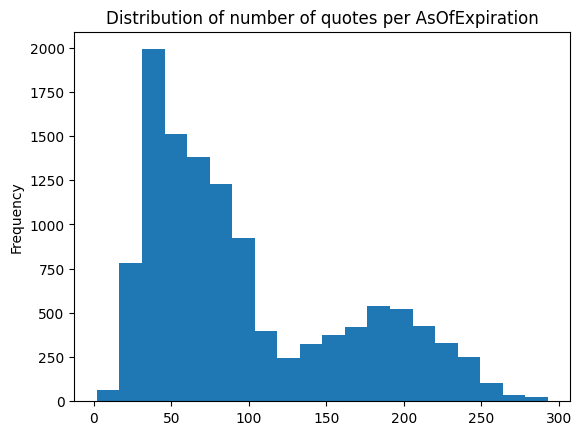

In [14]:
df_AsOfUnderlyingExpiration[('t', 'count')].plot(kind='hist', bins=20, title='Distribution of number of quotes per AsOfExpiration');

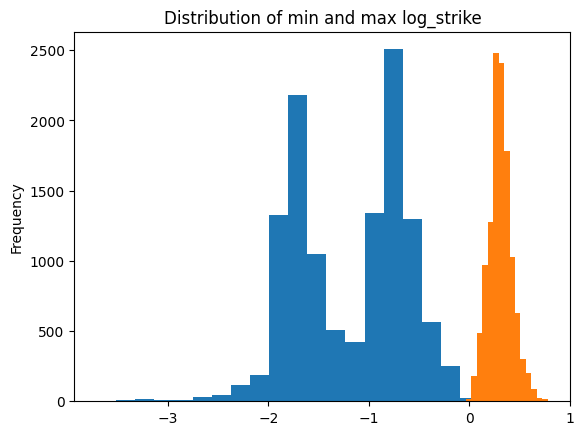

In [15]:
ax = df_AsOfUnderlyingExpiration[('log_strike', 'min')].plot(kind='hist', bins=20, title='Distribution of min and max log_strike');
df_AsOfUnderlyingExpiration[('log_strike', 'max')].plot(kind='hist', bins=20, ax=ax);

In [16]:
df_AsOfUnderlyingExpiration.shape

(11872, 3)

In [43]:
def get_valid_asof_expirations(log_strike_min: float = -0.5, log_strike_max: float = 0.2, min_strikes: int = 5) -> tuple[list, dict]:
    m1 = df_AsOfUnderlyingExpiration[('t', 'count')].ge(min_strikes)
    m2 = df_AsOfUnderlyingExpiration[('log_strike', 'min')].le(log_strike_min)
    m3 = df_AsOfUnderlyingExpiration[('log_strike', 'max')].ge(log_strike_max)
    valid_AsOfs = df_AsOfUnderlyingExpiration.loc[m1 * m2 * m3].groupby(['asof']).count().ge(3).iloc[:, 0].pipe(lambda x: x.loc[x]).index
    valid_expirations = {asof: df_AsOfUnderlyingExpiration.loc[m1 * m2 * m3 * (df_AsOfUnderlyingExpiration.index.get_level_values(0)==asof)].index.get_level_values(1) for asof in valid_AsOfs}

    return valid_AsOfs, valid_expirations
valid_AsOfs, valid_expirations = get_valid_asof_expirations(log_strike_min=-0.5, log_strike_max=0.15, min_strikes=6)

In [47]:
len(valid_AsOfs), valid_AsOfs[0], valid_AsOfs[-1]

(1643,
 Timestamp('2017-06-02 15:48:00-0400', tz='US/Eastern'),
 Timestamp('2024-10-25 15:48:00-0400', tz='US/Eastern'))

In [49]:
pd.Series(valid_AsOfs, name='asof').to_frame().assign(gap=lambda x: x['asof'].diff()).nlargest(5, 'gap')

,asof,gap
492,2020-01-30 15:48:00-05:00,22 days 00:00:00
45,2017-11-07 15:48:00-05:00,11 days 01:00:00
9,2017-07-17 15:48:00-04:00,11 days 00:00:00
53,2017-11-28 15:48:00-05:00,11 days 00:00:00
145,2018-05-29 15:48:00-04:00,11 days 00:00:00


In [52]:
strike_space = np.linspace(-0.5, 0.15, 11)

In [55]:
def get_date_X_y(asof: datetime.datetime, expirations: list[datetime.datetime], strike_space: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    mask = df['asof'].eq(asof)
    mask = mask & df['OTM'].eq(True)
    df_asof = df.loc[mask]

    X = np.empty((3, strike_space.size))
    y = np.empty(3)
    for j, expiration in enumerate(expirations[:3]):
        df_expiration = df_asof.loc[df_asof['expiration'].eq(expiration)].sort_values('strike_price')
        u = df_expiration['log_strike'].values
        v = df_expiration['iv_mid'].values
        curve = scipy.interpolate.interp1d(u, v, kind='cubic', bounds_error=True)
        X[j, :] = curve(strike_space)
        y[j] = df_expiration['t'].iloc[0]
    return X, y
# get_X_y(valid_AsOfs[0], expirations=valid_expirations[valid_AsOfs[0]], strike_space=strike_space)

In [58]:
def get_data(dates, strike_space):
    X, y = [], []
    
    for date in dates:
        X_single, y_single = get_date_X_y(date, valid_expirations[date], strike_space)
        X.append(X_single)
        y.append(y_single)
    X = np.asarray(X)  # For 2D arrays
    y = np.asarray(y)  # For 1D arrays
    return X, y

In [59]:
X, y = get_data(valid_AsOfs, strike_space)
X.shape, y.shape

((1643, 3, 11), (1643, 3))

In [61]:
X.shape, y.shape, np.isfinite(X).all(), np.isfinite(y).all()

((1643, 3, 11), (1643, 3), True, True)

In [62]:
def save_numpy_array_to_redis(conn, array, key):
    binary_data = array.tobytes()
    conn.set(f"np:{key}:data", binary_data)
    conn.set(f"np:{key}:metadata", f"{array.shape}|{array.dtype}")

def get_numpy_array_from_redis(conn, key):
    binary_data = conn.get(f"np:{key}:data")
    if binary_data is None:
        return None
    metadata = conn.get(f"np:{key}:metadata").decode('utf-8')
    shape, dtype = metadata.split('|')
    shape = eval(shape)
    array = np.frombuffer(binary_data, dtype=dtype).reshape(shape)
    return array

In [66]:
if True:
    save_numpy_array_to_redis(conn, X, 'X')
    save_numpy_array_to_redis(conn, y, 'y')

In [67]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax

In [461]:
class Encoder(eqx.Module):
    conv2d: eqx.nn.Conv2d
    fc1: eqx.nn.Linear
    fc_mu: eqx.nn.Linear
    fc_logvar: eqx.nn.Linear

    def __init__(
        self,
        height: int,
        width: int,
        out_channels: int,
        latent_dim: int,
        hidden_dim: int,
        *,
        key,
    ):
        keys = jax.random.split(key, 4)
        self.conv2d = eqx.nn.Conv2d(
            in_channels=1, out_channels=out_channels, kernel_size=(2, 3), key=keys[0]
        )
        self.fc1 = eqx.nn.Linear(
            out_channels * ((height - 1) * (width - 2)) + height,
            hidden_dim,
            key=keys[1],
        )
        self.fc_mu = eqx.nn.Linear(hidden_dim, latent_dim, key=keys[2])
        self.fc_logvar = eqx.nn.Linear(hidden_dim, latent_dim, key=keys[3])

    def __call__(self, x, y):
        x = (x - 0.25) / 0.1
        x = jnp.expand_dims(x, axis=0)
        x = self.conv2d(x)
        x = x.ravel()
        combined = jnp.concatenate((x, y))
        h = jax.nn.silu(self.fc1(combined))
        return self.fc_mu(h), self.fc_logvar(h)


class Decoder(eqx.Module):
    fc1: eqx.nn.Linear
    fc2: eqx.nn.Linear
    conv_transpose: eqx.nn.ConvTranspose2d
    height: int
    width: int
    out_channels: int

    def __init__(
        self,
        height: int,
        width: int,
        out_channels: int,
        latent_dim: int,
        hidden_dim: int,
        *,
        key,
    ):
        keys = jax.random.split(key, 3)

        # Calculate the size needed for the transposed convolution input
        self.height = height
        self.width = width
        self.out_channels = out_channels
        conv_output_size = out_channels * ((height - 1) * (width - 2))

        # Layers going from latent space back to conv input dimensions
        self.fc1 = eqx.nn.Linear(latent_dim + height, hidden_dim, key=keys[0])
        self.fc2 = eqx.nn.Linear(hidden_dim, conv_output_size, key=keys[1])

        # Transposed convolution to mirror the encoder's conv2d
        self.conv_transpose = eqx.nn.ConvTranspose2d(
            in_channels=out_channels, out_channels=1, kernel_size=(2, 3), key=keys[2]
        )

    def __call__(self, z, y):
        # Combine latent vector with condition
        combined = jnp.concatenate((z, y))

        # Pass through fully connected layers
        h = jax.nn.silu(self.fc1(combined))
        h = jax.nn.silu(self.fc2(h))

        # Reshape for transposed convolution
        h = h.reshape(self.out_channels, self.height - 1, self.width - 2)

        # Apply transposed convolution and remove the channel dimension
        x_reconstructed = self.conv_transpose(h)
        return jax.nn.softplus(x_reconstructed[0])  # Remove the batch dimension


class CVAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder
    latent_dim: int
    width: int
    height: int
    hidden_dim: int

    def __init__(
        self,
        height: int,
        width: int,
        out_channels: int,
        latent_dim: int,
        hidden_dim: int,
        *,
        key,
    ):
        keys = jax.random.split(key, 2)
        self.encoder = Encoder(
            height=height,
            width=width,
            out_channels=out_channels,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            key=keys[0],
        )
        self.decoder = Decoder(
            height=height,
            width=width,
            out_channels=out_channels,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            key=keys[1],
        )
        self.latent_dim = latent_dim
        self.width = width
        self.height = height
        self.hidden_dim = hidden_dim

    def reparameterize(self, mu, logvar, *, key):
        std = jnp.exp(0.5 * logvar)
        eps = jax.random.normal(key, std.shape)
        return mu + eps * std

    def __call__(self, x, y, *, key) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar, key=key)
        return self.decoder(z, y), mu, logvar

In [776]:
def correlation_loss(z):
    corr_matrix = jnp.corrcoef(z, rowvar=False)
    return jnp.power(corr_matrix[jnp.tril_indices(z.shape[1], k=-1)], 2).mean()

def loss_fn(model: CVAE, x: jnp.ndarray, y: jnp.ndarray, *, key, kl_loss_alpha: float = 1.0, correl_loss_alpha: float = 1.0) -> jnp.ndarray:
    _fn = lambda a, b: model(a, b, key=key)
    # recon_x, mu, logvar = model(x, y, key=key)
    recon_x, mu, logvar = jax.vmap(_fn)(x, y)
    
    # Reconstruction loss (MSE)
    recon_loss = jnp.power(x - recon_x, 2).mean((-2, -1)).mean()
    
    # KL divergence
    kl_loss = -0.5 * jnp.mean(1 + logvar - mu**2 - jnp.exp(logvar))
    
    return recon_loss + kl_loss_alpha * kl_loss + correl_loss_alpha * correlation_loss(mu)

@eqx.filter_value_and_grad
def batch_loss(model: CVAE, x: jnp.ndarray, y: jnp.ndarray, *, key, kl_loss_alpha: float = 1.0, correl_loss_alpha: float = 1.0) -> jnp.ndarray:
    # fn = lambda a, b : loss_fn(model, a, b, key=key, kl_loss_alpha=kl_loss_alpha)
    # return jax.vmap(fn)(x, y).sum()
    return loss_fn(model, x, y, key=key, kl_loss_alpha=kl_loss_alpha, correl_loss_alpha=correl_loss_alpha)

@eqx.filter_jit
def make_step(model: CVAE, x: jnp.ndarray, y: jnp.ndarray, opt_state, optimizer, *, key, kl_loss_alpha: float = 1.0, correl_loss_alpha: float = 1.0):
    loss, grads = batch_loss(model, x, y, key=key, kl_loss_alpha=kl_loss_alpha, correl_loss_alpha=correl_loss_alpha)
    updates, opt_state = optimizer.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [70]:
key_init, key_loop = jax.random.split(jax.random.PRNGKey(0))
model = CVAE(
    height=X.shape[1],
    width=X.shape[2],
    latent_dim=1,
    out_channels=4,
    hidden_dim=16,
    key=key_init,
)
optimizer = optax.adamw(learning_rate=1e-2)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

In [1373]:
# Training loop
num_epochs = 1000
BATCH_SIZE = 32

_n_batches = X.shape[0] // BATCH_SIZE
X_train = X[:_n_batches*BATCH_SIZE, :, :].reshape(_n_batches, BATCH_SIZE, *X.shape[-2:])
y_train = y[:_n_batches*BATCH_SIZE, :].reshape(_n_batches, BATCH_SIZE, y.shape[-1])

X_test = X[_n_batches*BATCH_SIZE:, :, :]
y_test = y[_n_batches*BATCH_SIZE:, :]

best_loss, best_model = np.inf, None
losses = []
test_losses = []
print_every = num_epochs // 20
for epoch in range(num_epochs):
    epoch_loss = 0.
    for batch_x, batch_y in zip(X_train, y_train):
        key_loop, key_train = jax.random.split(key_loop)
        loss, model, opt_state = make_step(model, batch_x, batch_y, opt_state, optimizer, key=key_train, kl_loss_alpha=1e-2, correl_loss_alpha=5e-2)
        epoch_loss += loss.item()

    test_loss = eqx.filter_jit(loss_fn)(model, X_test, y_test, key=key_train, kl_loss_alpha=0., correl_loss_alpha=0.) ## Only consider reconstruction loss
    test_losses.append(test_loss.item())
    losses.append(epoch_loss)
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model
    if (epoch % print_every) == 0 or (epoch == num_epochs - 1):
        print(f'{epoch=:4}, {epoch_loss=:8.4f} {test_loss=:7.4f}')
print(f'{best_loss=:.4f}')

epoch=   0, epoch_loss= 55.5010 test_loss= 0.0796
epoch=  50, epoch_loss=  5.2225 test_loss= 0.0309
epoch= 100, epoch_loss=  1.6716 test_loss= 0.0031
epoch= 150, epoch_loss=  2.0553 test_loss= 0.0032
epoch= 200, epoch_loss=  2.3406 test_loss= 0.0043
epoch= 250, epoch_loss=  2.4099 test_loss= 0.0017
epoch= 300, epoch_loss=  2.7809 test_loss= 0.0276
epoch= 350, epoch_loss=  2.4296 test_loss= 0.0019
epoch= 400, epoch_loss=  5.9125 test_loss= 0.0089
epoch= 450, epoch_loss=  2.1875 test_loss= 0.0027
epoch= 500, epoch_loss=  1.3007 test_loss= 0.0014
epoch= 550, epoch_loss=  1.1649 test_loss= 0.0026
epoch= 600, epoch_loss=  1.3450 test_loss= 0.0027
epoch= 650, epoch_loss=  2.9601 test_loss= 0.0036
epoch= 700, epoch_loss=  1.6592 test_loss= 0.0010
epoch= 750, epoch_loss=  1.6746 test_loss= 0.0047
epoch= 800, epoch_loss=  1.5886 test_loss= 0.0033
epoch= 850, epoch_loss=  1.5051 test_loss= 0.0025
epoch= 900, epoch_loss=  5.3384 test_loss= 0.0480
epoch= 950, epoch_loss=  5.0363 test_loss= 0.0542


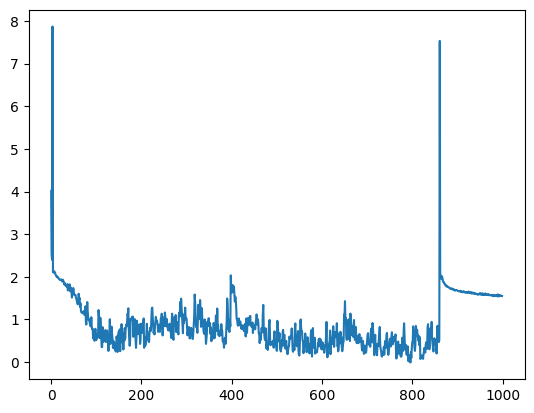

In [1374]:
pd.Series(losses).apply(np.log).plot();

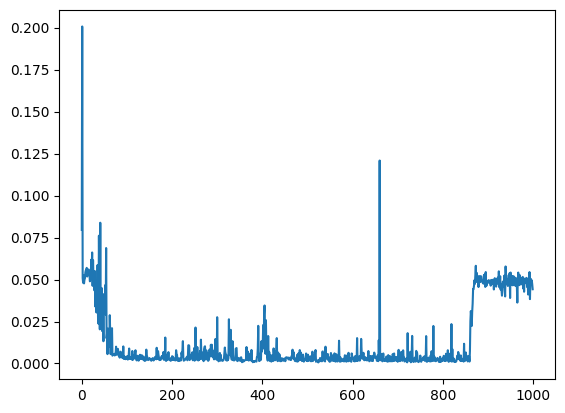

In [1375]:
pd.Series(test_losses).plot();

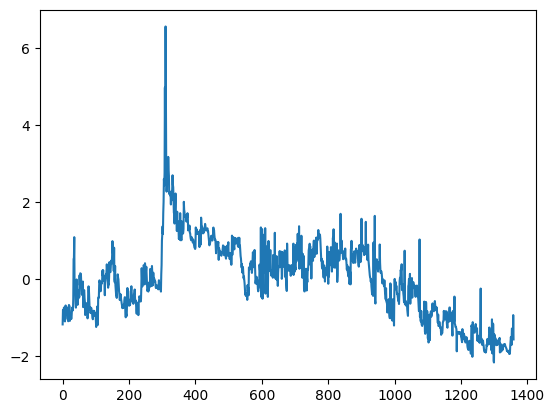

In [1376]:
reconstructed, latent, logvar = jax.vmap(lambda a, b: best_model(a, b, key=jax.random.PRNGKey(0)))(X, y)
plt.plot(latent);

In [1356]:
np.corrcoef(latent.T).round(2)

array([[1.  , 0.99],
       [0.99, 1.  ]])

In [1377]:
latent.mean(0).round(3)

Array([-0.034], dtype=float64)

In [1378]:
latent.std(0).round(3)

Array([1.004], dtype=float64)

In [73]:
def load_data_from_redis(conn) -> tuple[np.ndarray, np.ndarray]:
    return get_numpy_array_from_redis(conn, 'X'), get_numpy_array_from_redis(conn, 'y')

In [84]:
RunInfo = namedtuple('RunInfo', 'model best_loss')

def run_for_param_set(
    latent_dim: int,
    out_channels: int,
    hidden_dim: int,
    seed: int,
    learning_rate: float,
    kl_loss_alpha: float,
    correl_loss_alpha: float,
    num_epochs: int,
):
    X, y = load_data_from_redis(conn)
    
    key_init, key_loop = jax.random.split(jax.random.PRNGKey(seed))
    model = CVAE(
        height=X.shape[1],
        width=X.shape[2],
        latent_dim=latent_dim,
        out_channels=out_channels,
        hidden_dim=hidden_dim,
        key=key_init,
    )
    optimizer = optax.adam(learning_rate=learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    X_train, y_train, X_test, y_test = shapify_data(X, y, batch_size=32)
    
    best_loss, best_model = np.inf, None
    
    print_every = num_epochs // 20
    for epoch in range(num_epochs):
        epoch_loss = 0.
        for batch_x, batch_y in zip(X_train, y_train):
            key_loop, key_train, key_test = jax.random.split(key_loop, 3)
            loss, model, opt_state = make_step(model, batch_x, batch_y, opt_state, optimizer, key=key_train, kl_loss_alpha=kl_loss_alpha, correl_loss_alpha=correl_loss_alpha)
            epoch_loss += loss.item()
    
        test_loss = loss_fn(model, X_test, y_test, key=key_test, kl_loss_alpha=0., correl_loss_alpha=0.).item() ## Only consider reconstruction loss
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model

    return RunInfo(best_model, best_loss)

In [90]:
pd.Series(np.exp(strike_space)).round(2)

0     0.61
1     0.65
2     0.69
3     0.74
4     0.79
5     0.84
6     0.90
7     0.96
8     1.02
9     1.09
10    1.16
dtype: float64

In [91]:
def traditional_metrics_func(x, y):
    return dict(
        atmf=x[1, 7],
        ts=x[2, 7] - x[0, 7],
        skew=x[1, 5] - x[1, 9],
        norm_skew=(x[1, 5] - x[1, 9]) / x[1, 7],
        smile=0.5*(x[1, 5] + x[1, 9]) - x[1, 7],
    )
traditional_metrics = jax.vmap(traditional_metrics_func)(X, y)

In [92]:
df_metrics = pd.DataFrame(traditional_metrics, index=valid_AsOfs)
df_metrics = pd.concat((df_metrics, pd.DataFrame(latent, index=valid_AsOfs, columns=[f'latent{j}' for j in range(latent.shape[1])])), axis=1)
# df_metrics = pd.concat((df_metrics, pd.DataFrame(decomposition.PCA().fit_transform(latent), index=valid_AsOfs, columns=[f'latentPCA{j}' for j in range(latent.shape[1])])), axis=1)
df_metrics = pd.concat((df_metrics, pd.DataFrame(y, index=valid_AsOfs, columns=[f'y{j}' for j in range(y.shape[1])])), axis=1)
df_metrics.head()

NameError: name 'latent' is not defined

In [1382]:
df_metrics.corr().round(2)

,atmf,norm_skew,skew,smile,ts,latent0,y0,y1,y2
atmf,1.00,-0.65,0.61,-0.71,-0.64,0.90,-0.33,-0.27,-0.20
norm_skew,-0.65,1.00,0.12,0.59,0.41,-0.46,0.13,0.03,0.02
skew,0.61,0.12,1.00,-0.44,-0.20,0.70,-0.31,-0.32,-0.25
smile,-0.71,0.59,-0.44,1.00,0.39,-0.71,-0.02,-0.06,-0.05
ts,-0.64,0.41,-0.20,0.39,1.00,-0.54,0.16,0.16,0.12
latent0,0.90,-0.46,0.70,-0.71,-0.54,1.00,-0.02,0.01,0.02
y0,-0.33,0.13,-0.31,-0.02,0.16,-0.02,1.00,0.87,0.64
y1,-0.27,0.03,-0.32,-0.06,0.16,0.01,0.87,1.00,0.77
y2,-0.20,0.02,-0.25,-0.05,0.12,0.02,0.64,0.77,1.00


In [1383]:
PCA().fit(df_metrics[[x for x in df_metrics.columns if x in traditional_metrics]]).explained_variance_ratio_.round(3)

array([0.841, 0.122, 0.033, 0.003, 0.001])

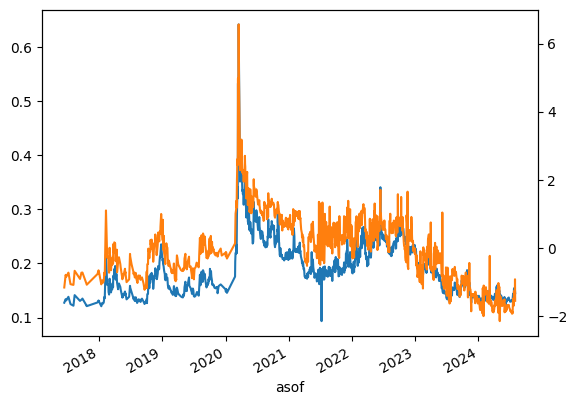

In [1384]:
ax = df_metrics['atmf'].plot();
df_metrics['latent0'].plot(ax=ax, secondary_y=True);

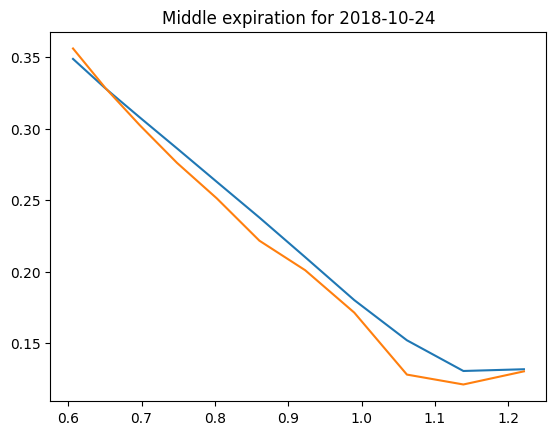

In [1385]:
j = 120
plt.plot(np.exp(strike_space), X[j, 1].T);
plt.plot(np.exp(strike_space), reconstructed[j, 1].T);
plt.title(f'Middle expiration for {valid_AsOfs[j].strftime("%Y-%m-%d")}');

In [1386]:
def compute_decoder_gradients(decoder, z, y):
    """
    Compute gradients of decoder output with respect to latent vector z
    
    Args:
        decoder: The decoder model
        z: Latent vector
        y: Condition vector
    Returns:
        reconstruction and gradients for each output element
    """
    # Get reconstruction
    reconstruction = decoder(z, y)
    
    # Function to get gradient for a single element
    def get_element_gradient(i, j):
        def element_output(z_input):
            return decoder(z_input, y)[i, j]
        
        _, grad = eqx.filter_value_and_grad(element_output)(z)
        return grad
    
    # Compute gradients for each element
    gradients = jnp.zeros((3, 11, len(z)))  # shape: (height, width, latent_dim)
    for i in range(3):
        for j in range(11):
            gradients = gradients.at[i, j].set(get_element_gradient(i, j))
    
    return reconstruction, gradients

In [1387]:
z = jnp.zeros(best_model.latent_dim)
_, gradients = compute_decoder_gradients(best_model.decoder, z, y[j])
gradients.shape

(3, 11, 1)

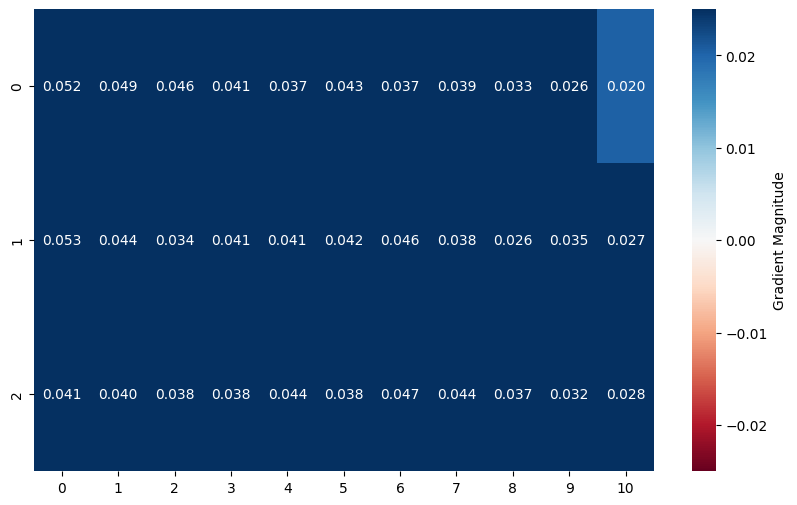

In [1388]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(gradients[:, :, 0], 
                annot=True,  # Show values in cells
                vmin=-0.025,
                vmax=0.025,
                fmt='.3f',   # Format for values
                cmap='RdBu', # Use blue color scheme
                cbar_kws={'label': 'Gradient Magnitude'});

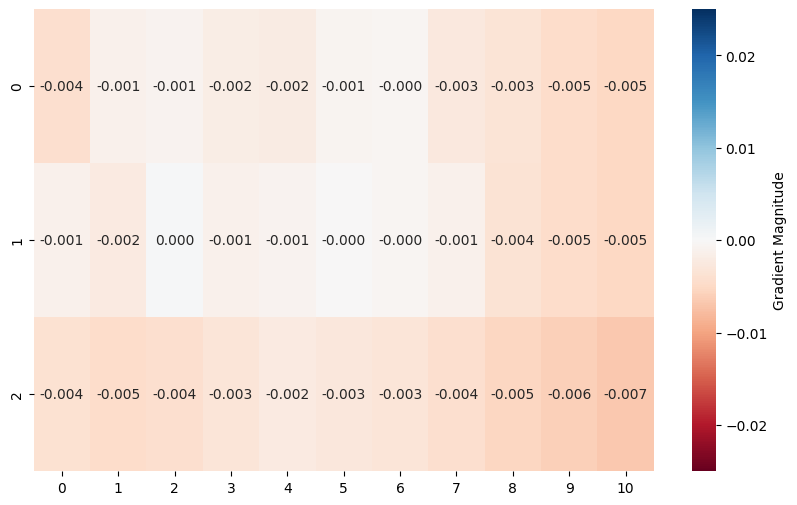

In [1264]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(gradients[:, :, 1], 
                annot=True,  # Show values in cells
                vmin=-0.025,
                vmax=0.025,
                fmt='.3f',   # Format for values
                cmap='RdBu', # Use blue color scheme
                cbar_kws={'label': 'Gradient Magnitude'},);

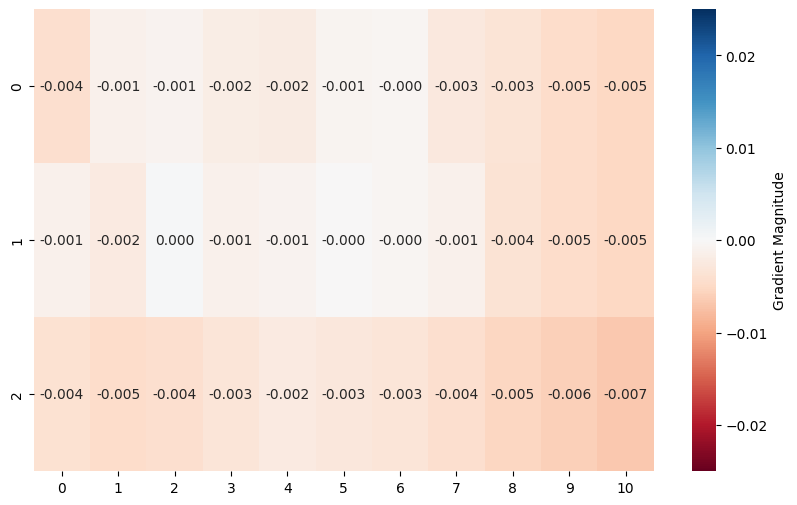

In [1265]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(gradients[:, :, 2], 
                annot=True,  # Show values in cells
                vmin=-0.025,
                vmax=0.025,
                fmt='.3f',   # Format for values
                cmap='RdBu', # Use blue color scheme
                cbar_kws={'label': 'Gradient Magnitude'},);

In [1113]:
params = {}
metrics = {}
results = {}
for token in conn.smembers('run:'):
    token = token.decode()
    key = f'results:{token}'
    if conn.exists(key):
        results[token] = float(conn.get(key))
        params[token] = {key.decode(): pd.to_numeric(value.decode()) for key, value in conn.hgetall(f'param_set:{token}').items()}
        metrics[token] = {key.decode(): pd.to_numeric(value.decode()) if value.decode() != 'nan' else NaN for key, value in conn.hgetall(f'metrics:{token}').items()}

df_res = pd.concat((pd.DataFrame(params).T, pd.Series(results, name='loss')), axis=1)
df_res = pd.concat((df_res, pd.DataFrame({key: value for key, value in metrics.items() if value}).T.drop(['latent_dim'], axis=1)), axis=1)
for col in ['latent_dim', 'out_channels', 'hidden_dim', 'seed', 'num_epochs']:
    df_res[col] = df_res[col].astype(int)
print(df_res.shape)
df_res.head()

(1875, 23)


,latent_dim,out_channels,hidden_dim,seed,learning_rate,kl_loss_alpha,correl_loss_alpha,num_epochs,loss,recon_loss,KL_loss,correl_loss,logpdf,loc_0,scale_0,loc_1,scale_1,loc_2,scale_2,loc_3,scale_3,loc_,scale_
BQJZ,4,0,16,0,0.003162,0.001,0.001,1000,0.000766,0.000370,0.321528,0.017918,-1.021147,-0.050113,0.130177,-0.003488,0.112453,-0.080910,0.874599,-0.009069,0.118316,-0.035895,0.450697
BRSP,4,0,48,1,0.017783,0.001,0.001,1000,0.003521,0.002586,0.228131,0.370776,-1.030650,0.140698,0.366876,0.071201,0.397723,0.390937,0.463132,-0.366438,0.272841,0.059100,0.468966
BRUY,4,0,4,2,0.000100,0.100,0.010,1000,0.005066,0.003420,0.000056,0.146335,-0.918992,0.001067,0.005973,-0.001967,0.014346,-0.001176,0.010875,0.000222,0.007788,-0.000464,0.010320
BRTQ,4,0,48,1,0.100000,0.001,0.100,1000,0.216082,0.084857,191.778082,0.416133,-163.182393,-0.315530,6.726625,-0.396982,5.159679,7.403807,26.202065,-9.214067,19.992927,-0.630693,18.003587
BRIH,4,0,16,1,0.003162,0.010,0.100,1000,0.004760,0.001764,0.079824,0.113201,-0.994486,-0.015832,0.280845,-0.097551,0.357409,-0.189643,0.470189,-0.073507,0.354339,-0.094133,0.377140


In [1114]:
df_res.describe().round(3)

/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,latent_dim,out_channels,hidden_dim,seed,learning_rate,kl_loss_alpha,correl_loss_alpha,num_epochs,loss,recon_loss,KL_loss,correl_loss,logpdf,loc_0,scale_0,loc_1,scale_1,loc_2,scale_2,loc_3,scale_3,loc_,scale_
count,1875.0,1875.0,1875.000,1875.000,1875.000,1875.000,1875.000,1875.0,1.875000e+03,1872.000,1875.000,1875.000,1875.000,1875.000,1875.000,1875.000,1875.000,1875.000,1875.000,1875.000,1875.000,1875.000,1875.000
mean,4.0,0.0,20.000,1.000,0.024,0.022,0.022,1000.0,6.896911e+215,inf,inf,0.262,-4313.677,-2.361,5.560,2.142,5.781,2.780,5.826,-0.694,4.236,0.467,8.364
std,0.0,0.0,15.599,0.817,0.038,0.039,0.039,0.0,inf,NaN,NaN,0.252,129178.857,79.325,55.695,87.232,58.489,87.752,66.693,31.934,28.154,25.355,88.978
min,4.0,0.0,4.000,0.000,0.000,0.000,0.000,1000.0,0.000000e+00,0.000,0.000,0.000,-5457359.409,-3042.324,0.000,-824.222,0.000,-764.381,0.000,-952.267,0.000,-387.589,0.000
25%,4.0,0.0,8.000,0.000,0.001,0.000,0.000,1000.0,1.000000e-03,0.001,0.033,0.078,-1.664,-0.122,0.025,-0.143,0.029,-0.140,0.029,-0.126,0.023,-0.116,0.128
50%,4.0,0.0,16.000,1.000,0.003,0.001,0.001,1000.0,2.000000e-03,0.003,0.382,0.172,-1.049,-0.004,0.144,-0.004,0.173,-0.005,0.272,-0.002,0.146,-0.012,0.493
75%,4.0,0.0,24.000,2.000,0.018,0.010,0.010,1000.0,7.000000e-03,0.004,2.601,0.364,-0.932,0.035,0.828,0.035,0.864,0.057,0.983,0.038,0.887,0.013,1.128
max,4.0,0.0,48.000,2.000,0.100,0.100,0.100,1000.0,1.293171e+219,inf,inf,1.000,-0.919,990.512,1685.386,3482.075,1933.047,3464.984,1915.465,500.155,797.093,943.176,3166.250


In [1115]:
df_res.query('out_channels==0').nsmallest(10, 'loss').round(5)

,latent_dim,out_channels,hidden_dim,seed,learning_rate,kl_loss_alpha,correl_loss_alpha,num_epochs,loss,recon_loss,KL_loss,correl_loss,logpdf,loc_0,scale_0,loc_1,scale_1,loc_2,scale_2,loc_3,scale_3,loc_,scale_
BSOH,4,0,48,2,0.00056,0.00001,0.00010,1000,0.00017,0.00005,2.67713,0.24877,-1.39402,-0.36668,0.66488,-0.49243,0.83079,0.63654,1.16185,-0.17071,0.71221,-0.09832,0.96979
BRQF,4,0,48,1,0.00056,0.00001,0.00001,1000,0.00018,0.00003,2.27387,0.23647,-1.28102,0.07341,0.18207,-0.02635,0.70378,0.77953,1.02042,0.13591,0.83350,0.24063,0.81625
BSOG,4,0,48,2,0.00056,0.00001,0.00001,1000,0.00018,0.00005,2.19400,0.02181,-1.34755,-0.12656,0.79601,-0.20941,0.98057,0.50409,1.21568,-0.06009,0.19559,0.02701,0.92547
BRRF,4,0,48,1,0.00316,0.00001,0.00010,1000,0.00018,0.00017,2.64066,0.23973,-1.49891,0.25530,0.88623,-0.15953,0.33849,1.50801,1.02178,-0.04509,0.57356,0.38967,1.00404
BRRE,4,0,48,1,0.00316,0.00001,0.00001,1000,0.00018,0.00012,2.99319,0.12183,-1.51028,-0.37978,0.88711,0.19469,0.71390,1.11809,1.24641,0.24882,0.62160,0.29545,1.04661
BRMK,4,0,24,1,0.00316,0.00001,0.00010,1000,0.00019,0.00008,2.26771,0.04335,-1.29791,0.22498,0.75101,-0.08275,0.33231,-0.01500,0.72524,-0.72181,1.11922,-0.14865,0.85782
BRQG,4,0,48,1,0.00056,0.00001,0.00010,1000,0.00019,0.00004,2.21524,0.17946,-1.29670,0.17621,0.83325,0.01256,0.15760,0.68591,1.01600,0.17663,0.85895,0.26283,0.82852
BQTD,4,0,48,0,0.00316,0.00001,0.00001,1000,0.00019,0.00014,2.62404,0.21754,-1.72230,0.00086,0.09676,0.00161,0.83170,-1.99636,1.16629,-0.13255,0.60212,-0.53161,1.15070
BSPF,4,0,48,2,0.00316,0.00001,0.00001,1000,0.00019,0.00026,2.42651,0.10213,-1.82012,-0.04324,0.19238,-0.33366,0.87916,2.20512,1.17858,0.04892,0.17968,0.46929,1.25783
BQTE,4,0,48,0,0.00316,0.00001,0.00010,1000,0.00020,0.00013,3.01125,0.09476,-1.54214,-0.33867,0.60423,-0.53137,0.63875,-1.59446,1.05206,-0.06254,0.40303,-0.63176,0.92048


In [1116]:
df_res.query('correl_loss_alpha > 0').pivot_table(index=['latent_dim', 'out_channels', 'hidden_dim', 'learning_rate', 'kl_loss_alpha', 'correl_loss_alpha', ], columns='seed', values='loss').dropna().shape[0]

625

In [1117]:
df_res.query('correl_loss_alpha > 0 and loss != inf').pivot_table(index=['latent_dim', 'out_channels', 'hidden_dim', 'learning_rate', 'kl_loss_alpha', 'correl_loss_alpha', ], columns='seed', values='loss') \
    .assign(loc=lambda x: x[[0, 1, 2]].mean(1), std=lambda x: x[[0, 1, 2]].std(1), mn=lambda x: x[[0, 1, 2]].min(1), mx=lambda x: x[[0, 1, 2]].max(1)) \
    .dropna().nsmallest(10, 'mx').round(5)

/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


seed                                                                                    0  \
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha            
4          0            48         0.003162      0.00001       0.00001            0.00019   
                                   0.000562      0.00001       0.00010            0.00020   
                                                               0.00001            0.00021   
                        24         0.003162      0.00001       0.00010            0.00022   
                        16         0.003162      0.00001       0.00001            0.00021   
                        24         0.003162      0.00001       0.00001            0.00024   
                        16         0.003162      0.00001       0.00010            0.00021   
                        48         0.003162      0.00001       0.00010            0.00020   
                                   0.000562      0.00001       0.00100            0.00025   
                        16         0.000562      0.00001       0.00010            0.00025   

seed                                                                                    1  \
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha            
4          0            48         0.003162      0.00001       0.00001            0.00018   
                                   0.000562      0.00001       0.00010            0.00019   
                                                               0.00001            0.00018   
                        24         0.003162      0.00001       0.00010            0.00019   
                        16         0.003162      0.00001       0.00001            0.00023   
                        24         0.003162      0.00001       0.00001            0.00021   
                        16         0.003162      0.00001       0.00010            0.00025   
                        48         0.003162      0.00001       0.00010            0.00018   
                                   0.000562      0.00001       0.00100            0.00028   
                        16         0.000562      0.00001       0.00010            0.00026   

seed                                                                                    2  \
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha            
4          0            48         0.003162      0.00001       0.00001            0.00019   
                                   0.000562      0.00001       0.00010            0.00017   
                                                               0.00001            0.00018   
                        24         0.003162      0.00001       0.00010            0.00021   
                        16         0.003162      0.00001       0.00001            0.00022   
                        24         0.003162      0.00001       0.00001            0.00022   
                        16         0.003162      0.00001       0.00010            0.00024   
                        48         0.003162      0.00001       0.00010            0.00026   
                                   0.000562      0.00001       0.00100            0.00027   
                        16         0.000562      0.00001       0.00010            0.00030   

seed                                                                                  loc  \
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha            
4          0            48         0.003162      0.00001       0.00001            0.00019   
                                   0.000562      0.00001       0.00010            0.00019   
                                                               0.00001            0.00019   
                        24         0.003162      0.00001       0.00010            0.00020   
                        16         0.003162      0.00001       0.00001            0.00022  

In [1125]:
df_res.query('correl_loss_alpha > 0 and loss != inf').pivot_table(index=['latent_dim', 'out_channels', 'hidden_dim', 'learning_rate', 'kl_loss_alpha', 'correl_loss_alpha', ], columns='seed', values=['loss', 'correl_loss']) \
    .assign(loc=lambda x: x[[('loss', 0), ('loss', 1), ('loss', 2)]].mean(1), std=lambda x: x[[('loss', 0), ('loss', 1), ('loss', 2)]].std(1),mx=lambda x: x[[('loss', 0), ('loss', 1), ('loss', 2)]].max(1)) \
    .dropna().nsmallest(10, 'mx').round(5)

/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


correl_loss  \
seed                                                                                       0   
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha               
4          0            48         0.003162      0.00001       0.00001               0.21754   
                                   0.000562      0.00001       0.00010               0.09447   
                                                               0.00001               0.09854   
                        24         0.003162      0.00001       0.00010               0.18759   
                        16         0.003162      0.00001       0.00001               0.15485   
                        24         0.003162      0.00001       0.00001               0.18868   
                        16         0.003162      0.00001       0.00010               0.11981   
                        48         0.003162      0.00001       0.00010               0.09476   
                                   0.000562      0.00001       0.00100               0.17736   
                        16         0.000562      0.00001       0.00010               0.16654   

                                                                                           \
seed                                                                                    1   
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha            
4          0            48         0.003162      0.00001       0.00001            0.12183   
                                   0.000562      0.00001       0.00010            0.17946   
                                                               0.00001            0.23647   
                        24         0.003162      0.00001       0.00010            0.04335   
                        16         0.003162      0.00001       0.00001            0.10194   
                        24         0.003162      0.00001       0.00001            0.27129   
                        16         0.003162      0.00001       0.00010            0.13866   
                        48         0.003162      0.00001       0.00010            0.23973   
                                   0.000562      0.00001       0.00100            0.09981   
                        16         0.000562      0.00001       0.00010            0.39059   

                                                                                           \
seed                                                                                    2   
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha            
4          0            48         0.003162      0.00001       0.00001            0.10213   
                                   0.000562      0.00001       0.00010            0.24877   
                                                               0.00001            0.02181   
                        24         0.003162      0.00001       0.00010            0.19731   
                        16         0.003162      0.00001       0.00001            0.07388   
                        24         0.003162      0.00001       0.00001            0.26489   
                        16         0.003162      0.00001       0.00010            0.12774   
                        48         0.003162      0.00001       0.00010            0.10072   
                                   0.000562      0.00001       0.00100            0.09032   
                        16         0.000562      0.00001       0.00010            0.17451   

                                                                                     loss  \
seed                                                                                    0   
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha            
4          0            48         0.003162      0.00001       0.00001            0.00019   
                                   0.000

In [1118]:
df_res.query('correl_loss_alpha > 0 and loss != inf').pivot_table(index=['latent_dim', 'out_channels', 'hidden_dim', 'learning_rate', 'kl_loss_alpha', 'correl_loss_alpha', ], columns='seed', values='loss') \
    .assign(loc=lambda x: x[[0, 1, 2]].mean(1), std=lambda x: x[[0, 1, 2]].std(1), mn=lambda x: x[[0, 1, 2]].min(1), mx=lambda x: x[[0, 1, 2]].max(1)) \
    .dropna().nsmallest(10, 'mx').apply(np.log).round(2)

/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


seed                                                                                 0  \
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha         
4          0            48         0.003162      0.00001       0.00001           -8.58   
                                   0.000562      0.00001       0.00010           -8.51   
                                                               0.00001           -8.47   
                        24         0.003162      0.00001       0.00010           -8.42   
                        16         0.003162      0.00001       0.00001           -8.49   
                        24         0.003162      0.00001       0.00001           -8.32   
                        16         0.003162      0.00001       0.00010           -8.47   
                        48         0.003162      0.00001       0.00010           -8.52   
                                   0.000562      0.00001       0.00100           -8.30   
                        16         0.000562      0.00001       0.00010           -8.30   

seed                                                                                 1  \
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha         
4          0            48         0.003162      0.00001       0.00001           -8.60   
                                   0.000562      0.00001       0.00010           -8.59   
                                                               0.00001           -8.65   
                        24         0.003162      0.00001       0.00010           -8.59   
                        16         0.003162      0.00001       0.00001           -8.39   
                        24         0.003162      0.00001       0.00001           -8.46   
                        16         0.003162      0.00001       0.00010           -8.29   
                        48         0.003162      0.00001       0.00010           -8.60   
                                   0.000562      0.00001       0.00100           -8.17   
                        16         0.000562      0.00001       0.00010           -8.27   

seed                                                                                 2  \
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha         
4          0            48         0.003162      0.00001       0.00001           -8.54   
                                   0.000562      0.00001       0.00010           -8.68   
                                                               0.00001           -8.63   
                        24         0.003162      0.00001       0.00010           -8.48   
                        16         0.003162      0.00001       0.00001           -8.40   
                        24         0.003162      0.00001       0.00001           -8.42   
                        16         0.003162      0.00001       0.00010           -8.32   
                        48         0.003162      0.00001       0.00010           -8.27   
                                   0.000562      0.00001       0.00100           -8.23   
                        16         0.000562      0.00001       0.00010           -8.13   

seed                                                                               loc  \
latent_dim out_channels hidden_dim learning_rate kl_loss_alpha correl_loss_alpha         
4          0            48         0.003162      0.00001       0.00001           -8.57   
                                   0.000562      0.00001       0.00010           -8.59   
                                                               0.00001           -8.58   
                        24         0.003162      0.00001       0.00010           -8.50   
                        16         0.003162      0.00001       0.00001           -8.43   
                        24         0.003162      0.00001       0.00001           -8.40   
                        16         0.

In [740]:
def run_tscv_for_param_set(
    latent_dim: int,
    out_channels: int,
    hidden_dim: int,
    seed: int,
    learning_rate: float,
    kl_loss_alpha: float,
    correl_loss_alpha: float,
    num_epochs: int,
):
    X, y = load_data_from_redis(conn)
    tscv = TimeSeriesSplit(n_splits=5).split(X)
    cv_losses = []

    for train_idx, test_idx in tscv:
        X_test = X[test_idx]
        y_test = y[test_idx]

        key_init, key_loop = jax.random.split(jax.random.PRNGKey(seed))
        model = CVAE(
            height=X.shape[1],
            width=X.shape[2],
            latent_dim=latent_dim,
            out_channels=out_channels,
            hidden_dim=hidden_dim,
            key=key_init,
        )
        optimizer = optax.adam(learning_rate=learning_rate)
        opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

        batch_generator = batch_index_generator(train_idx.size)
        cv_best_loss = np.inf
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            for batch_idx in batch_generator:
                batch_x = X[train_idx][batch_idx]
                batch_y = y[train_idx][batch_idx]

                key_loop, key_train, key_test = jax.random.split(key_loop, 3)
                loss, model, opt_state = make_step(
                    model,
                    batch_x,
                    batch_y,
                    opt_state,
                    optimizer,
                    key=key_train,
                    kl_loss_alpha=kl_loss_alpha,
                    correl_loss_alpha=correl_loss_alpha,
                )
                epoch_loss += loss.item()

            test_loss = loss_fn(
                model,
                X_test,
                y_test,
                key=key_test,
                kl_loss_alpha=0.0,
                correl_loss_alpha=0.0,
            ).item()  ## Only consider reconstruction loss
            if test_loss < cv_best_loss:
                cv_best_loss = test_loss
        cv_losses.append(cv_best_loss)
    cv_losses = np.asarray(cv_losses)
    return tscv_weighted_average(cv_losses)

In [741]:
def run_for_param_set(
    latent_dim: int,
    out_channels: int,
    hidden_dim: int,
    seed: int,
    learning_rate: float,
    kl_loss_alpha: float,
    correl_loss_alpha: float,
    num_epochs: int,
):
    X, y = load_data_from_redis(conn)
    train_idx, test_idx = np.arange(int(X.shape[0]*0.7)), np.arange(int(X.shape[0]*0.7), X.shape[0])
    X_test = X[test_idx]
    y_test = y[test_idx]

    key_init, key_loop = jax.random.split(jax.random.PRNGKey(seed))
    model = CVAE(
        height=X.shape[1],
        width=X.shape[2],
        latent_dim=latent_dim,
        out_channels=out_channels,
        hidden_dim=hidden_dim,
        key=key_init,
    )
    optimizer = optax.adam(learning_rate=learning_rate)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

    batch_generator = batch_index_generator(train_idx.size)
    best_loss = np.inf
    best_model = None
    for epoch in range(num_epochs):
        for batch_idx in batch_generator:
            batch_x = X[train_idx][batch_idx]
            batch_y = y[train_idx][batch_idx]

            key_loop, key_train, key_test = jax.random.split(key_loop, 3)
            loss, model, opt_state = make_step(
                model,
                batch_x,
                batch_y,
                opt_state,
                optimizer,
                key=key_train,
                kl_loss_alpha=kl_loss_alpha,
                correl_loss_alpha=correl_loss_alpha,
            )

        test_loss = loss_fn(
            model,
            X_test,
            y_test,
            key=key_test,
            kl_loss_alpha=0.0,
            correl_loss_alpha=0.0,
        ).item()  ## Only consider reconstruction loss
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model
    return best_loss, best_model

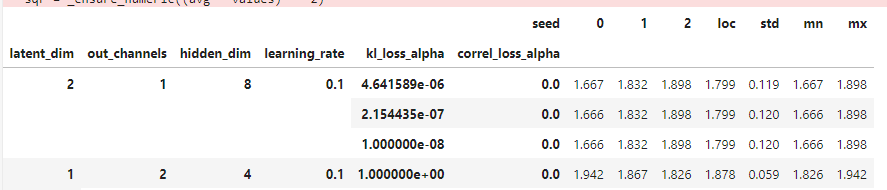

In [798]:
BEST_PARAMS = dict(latent_dim=4, out_channels=8, hidden_dim=16, learning_rate=0.017783, kl_loss_alpha=0.010, correl_loss_alpha=0.05, seed=0, num_epochs=1000)
best_loss, best_model = run_for_param_set(**BEST_PARAMS)
best_loss

0.01402484379823768

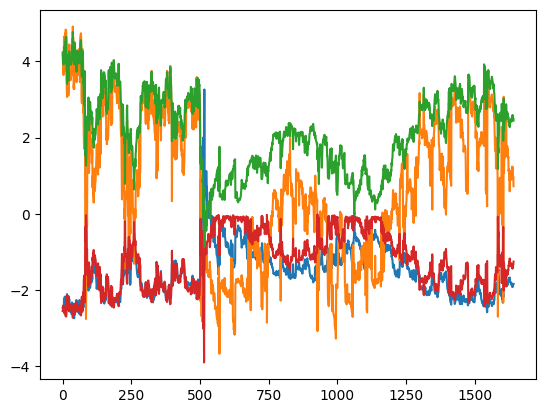

In [799]:
reconstructed, latent, logvar = jax.vmap(lambda a, b: best_model(a, b, key=jax.random.PRNGKey(0)))(X, y)
plt.plot(latent);

In [800]:
train_idx, test_idx = np.arange(int(X.shape[0]*0.7)), np.arange(int(X.shape[0]*0.7), X.shape[0])

In [801]:
jnp.power(X[train_idx] - reconstructed[train_idx], 2).mean((-2, -1)).mean(), jnp.power(X[test_idx] - reconstructed[test_idx], 2).mean((-2, -1)).mean()

(Array(0.01608707, dtype=float64), Array(0.0149403, dtype=float64))

In [802]:
jnp.corrcoef(latent.T).round(3)

Array([[ 1.   , -0.818, -0.938,  0.785],
       [-0.818,  1.   ,  0.942, -0.964],
       [-0.938,  0.942,  1.   , -0.937],
       [ 0.785, -0.964, -0.937,  1.   ]], dtype=float64)

In [803]:
PCA().fit(latent).explained_variance_ratio_.round(3)

array([0.959, 0.032, 0.007, 0.001])

In [720]:
samples = np.random.RandomState(32).multivariate_normal(np.zeros(2), cov=np.asarray([[1, 0.9], [0.9, 1.]]), size=1000)
samples.shape

(1000, 2)

In [722]:
correlation_loss(samples)

Array(0.80582759, dtype=float64)

In [723]:
def log_gaussian(x, mu, logvar):
    log2pi = jnp.log(2.0 * jnp.pi)
    return -0.5 * (log2pi + logvar + jnp.square(x - mu) / jnp.exp(logvar))

In [725]:
# log_gaussian(samples, np.zeros(2), np.zeros(2)).sum(-1)

In [726]:
np.cov(samples, rowvar=False)

array([[0.9726615 , 0.87336559],
       [0.87336559, 0.97316906]])

In [728]:
jax.scipy.stats.multivariate_normal.logpdf(samples, mean=np.zeros(2), cov=np.cov(samples, rowvar=False)).mean()

Array(-1.9904451, dtype=float64)

In [729]:
jax.scipy.stats.multivariate_normal.logpdf(samples, mean=np.zeros(2), cov=np.asarray([[1, 0.], [0., 1.]])).mean()

Array(-2.81072942, dtype=float64)

In [733]:
jax.scipy.stats.norm.logpdf(samples, loc=np.zeros(2), scale=np.ones(2)).sum(-1).mean()

Array(-2.81072942, dtype=float64)

In [623]:
jax.scipy.stats.norm.logpdf(samples[:, 0], 0., 1.).mean()

Array(-1.40751915, dtype=float64)

In [624]:
jax.scipy.stats.norm.logpdf(samples[:, 1], 0., 1.).mean()

Array(-1.40778467, dtype=float64)

In [944]:
X.shape

(1643, 3, 11)

In [953]:
pca = PCA(n_components=6).fit(X.reshape((1643, -1)))
pca

PCA(n_components=6)

In [955]:
pca.explained_variance_ratio_.round(3)

array([0.876, 0.085, 0.024, 0.007, 0.003, 0.002])

In [957]:
pca.components_.shape

(6, 33)

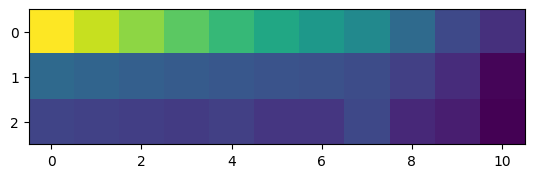

In [969]:
plt.imshow( pca.components_.reshape(6, 3, 11)[0] );

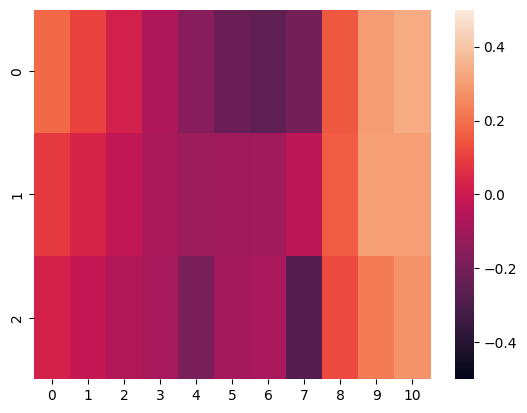

In [976]:
sns.heatmap(pca.components_.reshape(6, 3, 11)[3], vmin=-0.5, vmax=0.5);

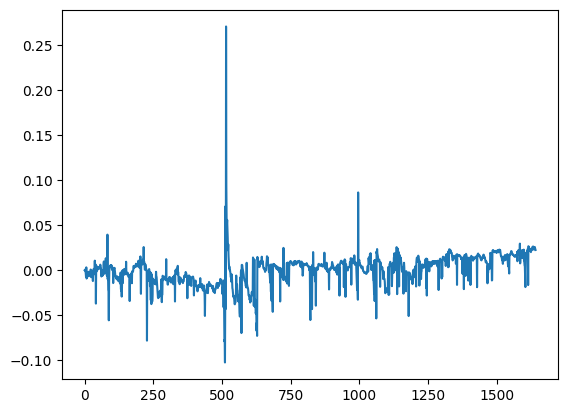

In [988]:
plt.plot( pca.fit_transform(X.reshape((-1, 3*11)))[:, 5] );

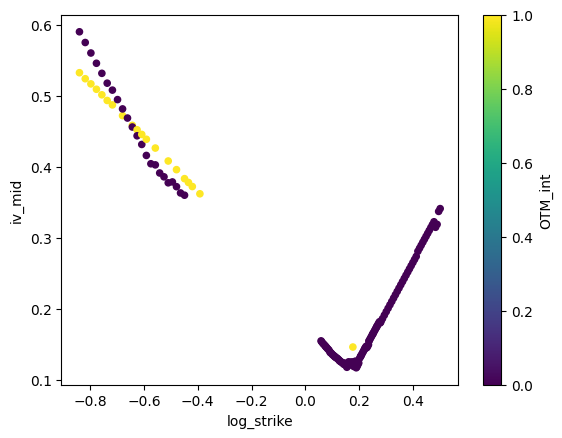

In [1163]:
df_quotes.loc[df_quotes['asof'].eq(pd.Timestamp('2018-10-26 15:48:00-0400', tz='US/Eastern'))] \
    .query('t>0.3 and t<0.4').assign(OTM_int=lambda x: x['OTM'].astype(int)) \
    .plot(kind='scatter', x='log_strike', y='iv_mid', c='OTM_int', cmap='viridis');

In [1171]:
df_quotes.loc[df_quotes['asof'].eq(pd.Timestamp('2018-10-26 15:48:00-0400', tz='US/Eastern'))].query('(not OTM) and log_strike>0')

,iv_model,fwd_model,symbol,asset,underlying,asof,expiration,fut_expiration,t,fwd,r,q,strike_price,instrument_class,bid,ask,iv_bid,iv_mid,iv_ask,log_strike,OTM
388528,bs_root,r_box_fwd_synth_mcmc,ESZ18 P2660,ES,ESZ8,2018-10-26 15:48:00-04:00,2018-12-21 09:30:00-05:00,2018-12-21 09:30:00-05:00,0.152715,2658.926798,0.007571,NaN,2660.0,P,81.75,83.00,0.196150,0.197660,0.199171,0.000404,False
388530,bs_root,r_box_fwd_synth_mcmc,ESZ18 P2670,ES,ESZ8,2018-10-26 15:48:00-04:00,2018-12-21 09:30:00-05:00,2018-12-21 09:30:00-05:00,0.152715,2658.926798,0.007571,NaN,2670.0,P,86.00,87.00,0.193698,0.194905,0.196113,0.004156,False
388532,bs_root,r_box_fwd_synth_mcmc,ESZ18 P2675,ES,ESZ8,2018-10-26 15:48:00-04:00,2018-12-21 09:30:00-05:00,2018-12-21 09:30:00-05:00,0.152715,2658.926798,0.007571,NaN,2675.0,P,88.25,89.25,0.192595,0.193804,0.195012,0.006027,False
388534,bs_root,r_box_fwd_synth_mcmc,ESZ18 P2680,ES,ESZ8,2018-10-26 15:48:00-04:00,2018-12-21 09:30:00-05:00,2018-12-21 09:30:00-05:00,0.152715,2658.926798,0.007571,NaN,2680.0,P,90.50,91.50,0.191371,0.192581,0.193792,0.007894,False
388536,bs_root,r_box_fwd_synth_mcmc,ESZ18 P2690,ES,ESZ8,2018-10-26 15:48:00-04:00,2018-12-21 09:30:00-05:00,2018-12-21 09:30:00-05:00,0.152715,2658.926798,0.007571,NaN,2690.0,P,95.00,96.00,0.188550,0.189766,0.190982,0.011619,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389869,bs_root,r_box_fwd_synth_mcmc,ESU19 P4325,ES,ESU9,2018-10-26 15:48:00-04:00,2019-09-20 09:30:00-04:00,2019-09-20 09:30:00-04:00,0.900034,2679.915841,0.007527,NaN,4325.0,P,1636.00,1650.75,0.212854,0.265717,0.295051,0.478627,False
389870,bs_root,r_box_fwd_synth_mcmc,ESU19 P4350,ES,ESU9,2018-10-26 15:48:00-04:00,2019-09-20 09:30:00-04:00,2019-09-20 09:30:00-04:00,0.900034,2679.915841,0.007527,NaN,4350.0,P,1661.00,1675.75,0.217179,0.269058,0.298335,0.484390,False
389871,bs_root,r_box_fwd_synth_mcmc,ESU19 P4375,ES,ESU9,2018-10-26 15:48:00-04:00,2019-09-20 09:30:00-04:00,2019-09-20 09:30:00-04:00,0.900034,2679.915841,0.007527,NaN,4375.0,P,1686.00,1700.75,0.221407,0.272380,0.301600,0.490121,False
389872,bs_root,r_box_fwd_synth_mcmc,ESU19 P4400,ES,ESU9,2018-10-26 15:48:00-04:00,2019-09-20 09:30:00-04:00,2019-09-20 09:30:00-04:00,0.900034,2679.915841,0.007527,NaN,4400.0,P,1711.00,1725.75,0.225549,0.275683,0.304847,0.495819,False
